In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_width, max_action):
        super(Actor, self).__init__()
        self.max_action = max_action
        self.l1 = nn.Linear(state_dim, hidden_width)
        self.l2 = nn.Linear(hidden_width, hidden_width)
        self.l3 = nn.Linear(hidden_width, action_dim)

    def forward(self, s):
        s = F.relu(self.l1(s))
        s = F.relu(self.l2(s))
        a = self.max_action * torch.tanh(self.l3(s))  # [-max,max]
        return a

In [ ]:
class Critic(nn.Module):  # According to (s,a), directly calculate Q(s,a)
    def __init__(self, state_dim, action_dim, hidden_width):
        super(Critic, self).__init__()
        self.l1 = nn.Linear(state_dim + action_dim, hidden_width)
        self.l2 = nn.Linear(hidden_width, hidden_width)
        self.l3 = nn.Linear(hidden_width, 1)

    def forward(self, s, a):
        q = F.relu(self.l1(torch.cat([s, a], 1)))
        q = F.relu(self.l2(q))
        q = self.l3(q)
        return q

In [ ]:
class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim):
        self.max_size = int(1e6)
        self.count = 0
        self.size = 0
        self.s = np.zeros((self.max_size, state_dim))
        self.a = np.zeros((self.max_size, action_dim))
        self.r = np.zeros((self.max_size, 1))
        self.s_ = np.zeros((self.max_size, state_dim))
        self.dw = np.zeros((self.max_size, 1))

    def store(self, s, a, r, s_, dw):
        self.s[self.count] = s
        self.a[self.count] = a
        self.r[self.count] = r
        self.s_[self.count] = s_
        self.dw[self.count] = dw
        self.count = (self.count + 1) % self.max_size  # When the 'count' reaches max_size, it will be reset to 0.
        self.size = min(self.size + 1, self.max_size)  # Record the number of  transitions

    def sample(self, batch_size):
        index = np.random.choice(self.size, size=batch_size)  # Randomly sampling
        batch_s = torch.tensor(self.s[index], dtype=torch.float)
        batch_a = torch.tensor(self.a[index], dtype=torch.float)
        batch_r = torch.tensor(self.r[index], dtype=torch.float)
        batch_s_ = torch.tensor(self.s_[index], dtype=torch.float)
        batch_dw = torch.tensor(self.dw[index], dtype=torch.float)

        return batch_s, batch_a, batch_r, batch_s_, batch_dw

In [ ]:
class DDPG(object):
    def __init__(self, state_dim, action_dim, max_action):
        self.hidden_width = 256  # The number of neurons in hidden layers of the neural network
        self.batch_size = 256  # batch size
        self.GAMMA = 0.99  # discount factor
        self.TAU = 0.005  # Softly update the target network
        self.lr = 3e-4  # learning rate

        self.actor = Actor(state_dim, action_dim, self.hidden_width, max_action)
        self.actor_target = copy.deepcopy(self.actor)
        self.critic = Critic(state_dim, action_dim, self.hidden_width)
        self.critic_target = copy.deepcopy(self.critic)

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=self.lr)

        self.MseLoss = nn.MSELoss()

    def choose_action(self, s):
        s = torch.unsqueeze(torch.tensor(s, dtype=torch.float), 0)
        a = self.actor(s).data.numpy().flatten()
        return a

    def learn(self, relay_buffer):
        batch_s, batch_a, batch_r, batch_s_, batch_dw = relay_buffer.sample(self.batch_size)  # Sample a batch

        # Compute the target Q
        with torch.no_grad():  # target_Q has no gradient
            Q_ = self.critic_target(batch_s_, self.actor_target(batch_s_))
            target_Q = batch_r + self.GAMMA * (1 - batch_dw) * Q_

        # Compute the current Q and the critic loss
        current_Q = self.critic(batch_s, batch_a)
        critic_loss = self.MseLoss(target_Q, current_Q)
        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Freeze critic networks so you don't waste computational effort
        for params in self.critic.parameters():
            params.requires_grad = False

        # Compute the actor loss
        actor_loss = -self.critic(batch_s, self.actor(batch_s)).mean()
        # Optimize the actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Unfreeze critic networks
        for params in self.critic.parameters():
            params.requires_grad = True

        # Softly update the target networks
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.TAU * param.data + (1 - self.TAU) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.TAU * param.data + (1 - self.TAU) * target_param.data)

In [ ]:
def evaluate_policy(env, agent):
    times = 3  # Perform three evaluations and calculate the average
    evaluate_reward = 0
    for _ in range(times):
        s = env.reset()
        done = False
        episode_reward = 0
        while not done:
            a = agent.choose_action(s)  # We do not add noise when evaluating
            s_, r, done, _ = env.step(a)
            episode_reward += r
            s = s_
        evaluate_reward += episode_reward

    return int(evaluate_reward / times)

Environment

In [ ]:
class StockMarketEnv:
    def __init__(self, price_data, news_data, stock_count=30, max_day=-1):
        # Data is a structured representation of your news, sentiments, and stock prices
        self.price_data = price_data
        self.news_data = news_data
        self.done = False
        self.current_day = 0
        self.price_column = price_data.columns
        self.news_column = news_data.columns
        if max_day == -1:
          self.max_day = len(self.price_data.columns)
        else:
          self.max_day = max_day

    def get_price_column(self, day):
      return self.price_data[self.price_column[day]].values

    def get_news_column(self, day):
      return self.news_data[self.news_column[day]].values

    def calculate_reward(self, action):
        sentiment_weight = 0.2
        price_movement_weight = 0.8

        if price_movement_weight !=0:
          price_diff = \
            self.get_price_column(self.current_day) - self.get_price_column(self.current_day-1)
          price_slope = np.sign(price_diff)
          price_reward = np.where(price_slope == action, 1, -1)
        else:
          price_reward = 0

        if sentiment_weight !=0:
          sentiment_reward = \
            np.where(self.get_news_column(self.current_day-1) == action, 1, -1)
        else:
          sentiment_reward = 0

        reward = sentiment_reward * sentiment_weight + price_reward * price_movement_weight
        return np.sum(reward)

    def reset(self):
        self.current_day = 0
        self.done = False
        self.state = self.get_price_column(self.current_day)
        price_data_tensor = torch.tensor(self.state)
        return price_data_tensor

    def step(self, action):
        self.current_day += 1
        self.state = self.get_price_column(self.current_day)
        reward = self.calculate_reward(action)
        if self.current_day >= len(self.price_column) - 2:
            self.done = True

        info = {'day': self.current_day, 'action_taken': action}

        return torch.tensor(self.state), torch.tensor(reward), self.done, info

    def render(self):
        # Optional: Implement rendering to visualize the environment
        pass


In [ ]:
import torch
import pandas as pd

In [ ]:
shape = (29, 8)
random_array = np.random.rand(*shape)
sentiment = pd.DataFrame(random_array)

In [ ]:
stock_price = pd.read_csv("stock_price.csv")

In [ ]:
stock_sentiment = pd.read_csv("final_sentiment.csv")

In [ ]:
stock_sentiment.head()

,Unnamed: 0,2024-03-22,2024-03-21,2024-03-28,2024-03-25,2024-03-29,2024-03-19,2024-03-26,2024-03-20,2024-03-27,2024-03-24,2024-03-23
0,AAPL,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0
1,AMZN,0.0,1.0,-1.0,1.0,0.0,1.0,-1.0,1.0,-1.0,1.0,0.0
2,BABA,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-1.0,0.0,0.0
3,BAC,1.0,-1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,CCL,-1.0,0.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,1.0,0.0,0.0


In [ ]:
stock_price.head()

,Unnamed: 0,2024-03-19,2024-03-20,2024-03-21,2024-03-22,2024-03-25,2024-03-26,2024-03-27,2024-03-28
0,TSLA,171.320007,175.660004,172.820007,170.830002,172.630005,177.669998,179.830002,175.789993
1,PLTR,23.799999,24.570000,24.490000,24.180000,24.510000,24.889999,24.510000,23.010000
2,NVDA,893.979980,903.719971,914.349976,942.890015,950.020020,925.609985,902.500000,903.559998
3,AAPL,176.080002,178.669998,171.369995,172.279999,170.850006,169.710007,173.309998,171.479996
4,META,496.239990,505.519989,507.760010,509.579987,503.019989,495.890015,493.859985,485.579987


In [ ]:
# Extract the stock names in the order from the stock_price_df
order = stock_price.iloc[:, 0].tolist()

# Set the first column of final_sentiment_df as the index for sorting
stock_sentiment.set_index(stock_sentiment.columns[0], inplace=True)

# Sort the final_sentiment_df based on the order extracted
sorted_final_sentiment = stock_sentiment.loc[order].reset_index()

sorted_final_sentiment.head()


,Unnamed: 0,2024-03-22,2024-03-21,2024-03-28,2024-03-25,2024-03-29,2024-03-19,2024-03-26,2024-03-20,2024-03-27,2024-03-24,2024-03-23
0,TSLA,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,0.0
1,PLTR,0.0,0.0,1.0,0.0,1.0,-1.0,0.0,0.0,1.0,0.0,0.0
2,NVDA,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,0.0
3,AAPL,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0
4,META,1.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,0.0


In [ ]:
sorted_final_sentiment.to_csv('sorted_final_sentiment.csv', index=False)

In [ ]:
stock_price_modified = stock_price.drop('Unnamed: 0', axis = 1)
stock_sentiment_modified = sorted_final_sentiment.drop('Unnamed: 0', axis = 1)
price_coluumn = stock_price_modified.columns.tolist()
sentiment_coluumn = stock_sentiment_modified.columns.tolist()

In [ ]:
ratio = 0.3
count = int(len(price_coluumn) * ratio)

X_train_price, X_test_price, x_train_news, x_test_news = \
  stock_price_modified[price_coluumn[:-count]], stock_price_modified[price_coluumn[-count:]], \
  stock_sentiment_modified[sentiment_coluumn[:-count]], stock_sentiment_modified[sentiment_coluumn[-count:]]

In [ ]:
count

2

In [ ]:
env = StockMarketEnv(X_train_price, x_train_news)
env_evaluate = StockMarketEnv(X_test_price, x_test_news)

state_dim = len(stock_price_modified)
action_dim = len(stock_price_modified)
max_action = 1.0  # Assume action values are normalized between [-1, 1]

agent = DDPG(state_dim, action_dim, max_action)
replay_buffer = ReplayBuffer(state_dim, action_dim)

# Training configurations
episodes = 10
max_steps = len(price_coluumn)
evaluate_freq = 1
evaluate_num = 0

total_reward = []
evaluate_rewards = {}

print("######")
evaluate_num += 1
evaluate_reward = evaluate_policy(env_evaluate, agent)
evaluate_rewards[0] = evaluate_reward
print("evaluate_num:{} \t evaluate_reward:{}".format(evaluate_num, evaluate_reward))
print("######")


for episode in range(episodes):
    reward_list = []

    state = env.reset()
    episode_reward = 0

    for step in range(max_steps):
        action = agent.choose_action(state)
        next_state, reward, done, info = env.step(action)
        replay_buffer.store(state, action, reward, next_state, done)
        agent.learn(replay_buffer)  # Perform one step of the optimization
        state = next_state
        episode_reward += reward
        reward_list.append(reward)

        if done:
            break
    total_reward.append(reward_list)

      # Evaluate the policy every 'evaluate_freq' steps
    if (episode + 1) % evaluate_freq == 0:
        print("######")
        evaluate_num += 1
        evaluate_reward = evaluate_policy(env_evaluate, agent)
        evaluate_rewards[episode] = evaluate_reward
        print("evaluate_num:{} \t evaluate_reward:{}".format(evaluate_num, evaluate_reward))
        print("######")



    print(f"Episode: {episode+1}, Reward: {episode_reward}, Max Step Reward: {max(reward_list)}")

    # Optional: Save the model and/or evaluate the policy periodically


######
evaluate_num:1 	 evaluate_reward:-8
######
######
evaluate_num:2 	 evaluate_reward:-3
######
Episode: 1, Reward: -18.4, Max Step Reward: -1.399999999999999


<ipython-input-39-cbe543080ce9>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.unsqueeze(torch.tensor(s, dtype=torch.float), 0)


######
evaluate_num:3 	 evaluate_reward:-1
######
Episode: 2, Reward: -4.399999999999997, Max Step Reward: 3.800000000000001
######
evaluate_num:4 	 evaluate_reward:-1
######
Episode: 3, Reward: -4.399999999999997, Max Step Reward: 3.800000000000001
######
evaluate_num:5 	 evaluate_reward:0
######
Episode: 4, Reward: -5.999999999999998, Max Step Reward: 2.2000000000000015
######
evaluate_num:6 	 evaluate_reward:0
######
Episode: 5, Reward: 2.800000000000003, Max Step Reward: 3.800000000000001
######
evaluate_num:7 	 evaluate_reward:0
######
Episode: 6, Reward: 0.8000000000000029, Max Step Reward: 3.800000000000001
######
evaluate_num:8 	 evaluate_reward:0
######
Episode: 7, Reward: -1.199999999999997, Max Step Reward: 3.800000000000001
######
evaluate_num:9 	 evaluate_reward:0
######
Episode: 8, Reward: -1.199999999999997, Max Step Reward: 3.800000000000001
######
evaluate_num:10 	 evaluate_reward:0
######
Episode: 9, Reward: -1.199999999999997, Max Step Reward: 3.800000000000001
#####

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

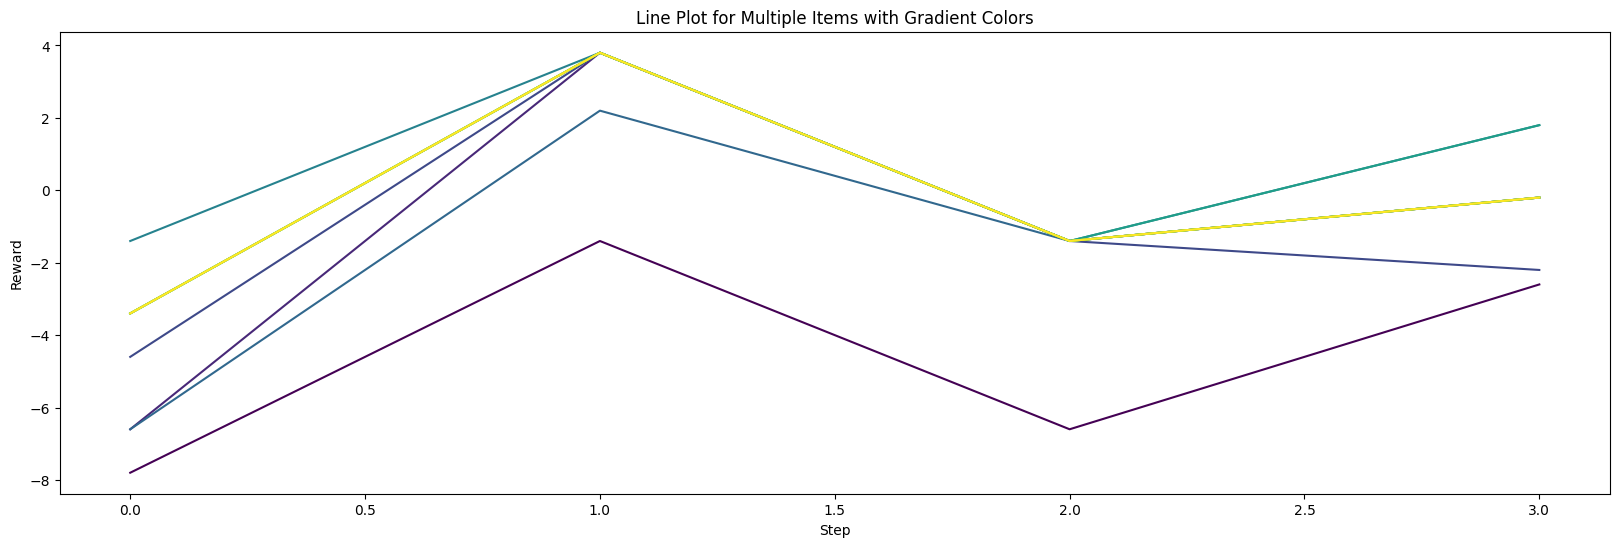

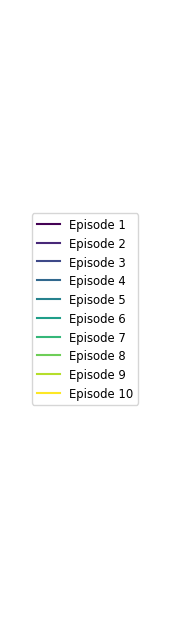

In [ ]:
# Choosing a colormap
colormap = cm.viridis  # You can try other colormaps like cm.plasma, cm.inferno, etc.

# Plotting each item in 'data' as a separate line with colors from the colormap
plt.figure(figsize=(20, 6))
colors = [colormap(i) for i in np.linspace(0, 1, len(total_reward))]
for i, (item, color) in enumerate(zip(total_reward, colors)):
    plt.plot(item, label=f'Episode {i+1}', color=color)

plt.title('Line Plot for Multiple Items with Gradient Colors')
plt.xlabel('Step')
plt.ylabel('Reward')
# plt.legend()
plt.savefig('plot.png')
plt.show()

# Create a figure for the legend
fig, ax = plt.subplots(figsize=(1.5, 6))  # Adjust figsize to fit your number of legend items
handles, labels = ax.get_legend_handles_labels()
colors = [colormap(i) for i in np.linspace(0, 1, len(total_reward))]

for i, (item, color) in enumerate(zip(total_reward, colors)):
    ax.plot([], [], label=f'Episode {i+1}', color=color)

# Create legend
ax.legend(loc='center', fontsize='small')

# Hide plot elements
ax.axis('off')

fig.canvas.draw()

# Adjust layout
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.savefig('fig.png')
plt.show()

In [ ]:

    # # Evaluate the policy every 'evaluate_freq' steps
    # if (max_steps + 1) % evaluate_freq == 0:
    #     evaluate_num += 1
    #     evaluate_reward = evaluate_policy(env_evaluate, agent)
    #     evaluate_rewards.append(evaluate_reward)
    #     print("evaluate_num:{} \t evaluate_reward:{}".format(evaluate_num, evaluate_reward))
    #     writer.add_scalar('step_rewards_{}'.format(env_name[env_index]), evaluate_reward, global_step=total_steps)
    #     # Save the rewards
    #     if evaluate_num % 10 == 0:
    #         np.save('./data_train/DDPG_env_{}_number_{}_seed_{}.npy'.format(env_name[env_index], number, seed), np.array(evaluate_rewards))



In [ ]:
evaluate_rewards.values()

dict_values([-3, -1, -1, 0, 0, 0, 0, 0, 0, 1])

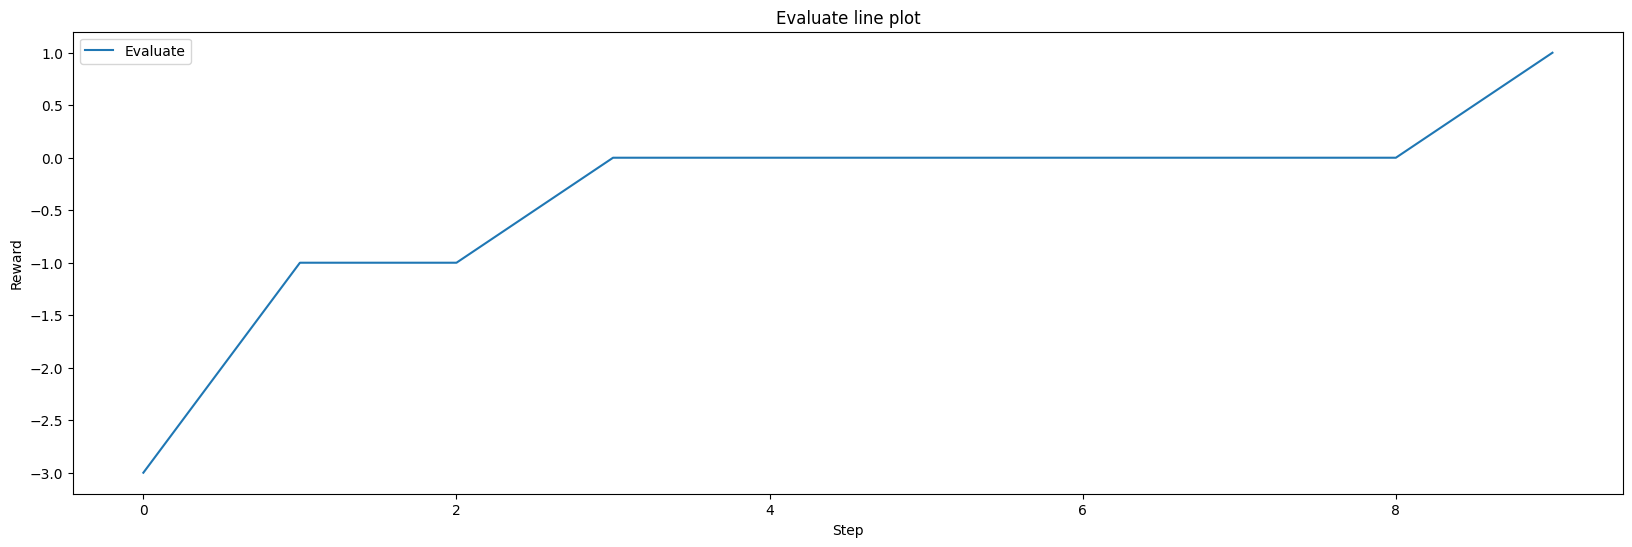

In [ ]:
# Choosing a colormap
colormap = cm.viridis  # You can try other colormaps like cm.plasma, cm.inferno, etc.

# Plotting each item in 'data' as a separate line with colors from the colormap
plt.figure(figsize=(20, 6))
plt.plot(evaluate_rewards.keys(), evaluate_rewards.values(), label="Evaluate")

plt.title('Evaluate line plot')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()
plt.savefig('eval.png')
plt.show()